# Autoencoder Model

## Extract the data

You must download the ``carpet.tar`` from MVTec offical webpage.

In [1]:
import os
import tarfile

# Nombre de la carpeta y del archivo tar
folder_name = "carpet"
tar_path = "carpet.tar"

# Solo extraer si la carpeta no existe
if not os.path.exists(folder_name):
    with tarfile.open(tar_path) as f:
        f.extractall(".")

## Visualize some examples

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = "carpet/test/hole/000.png"
image = Image.open(image_path)
print(image.size)

(1024, 1024)


torch.Size([3, 224, 224])


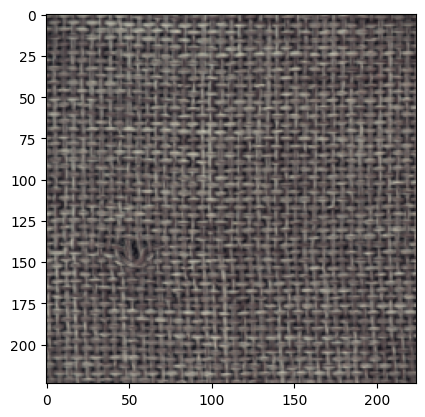

In [3]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Convert the image to a PyTorch tensor and divide by 255.0
])

image = transform(image)
print(image.shape)

plt.imshow(image.permute(1, 2, 0))
plt.show()

### Memory consumed by the tensor

In [4]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage of the tensor: {memory_usage * 279//1024} KB") # 279 is the number of samples we have

Memory usage of the tensor: 164052 KB


In [5]:
from torchvision.datasets import ImageFolder

train_image_path = "carpet/train"

good_dataset = ImageFolder(root=train_image_path, transform=transform)

x, y = good_dataset[0]

print("Image Shape:", x.shape)
print("Label:", y)

Image Shape: torch.Size([3, 224, 224])
Label: 0


### Train test split for the autoencoder

In [ ]:
import torch

train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 280
Number of samples in the training subset: 224
Number of samples in the testing subset: 56


### Using dataloader for efficient data loading during training

In [7]:
import torch
from torch.utils.data import DataLoader

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))

# Print the shape of the input images and labels
print(f"Shape of input images: {image_batch.shape}")
print(f"Shape of labels: {label_batch.shape}")

# Calculate the memory usage
memory_usage = image_batch.numel() * image_batch.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB


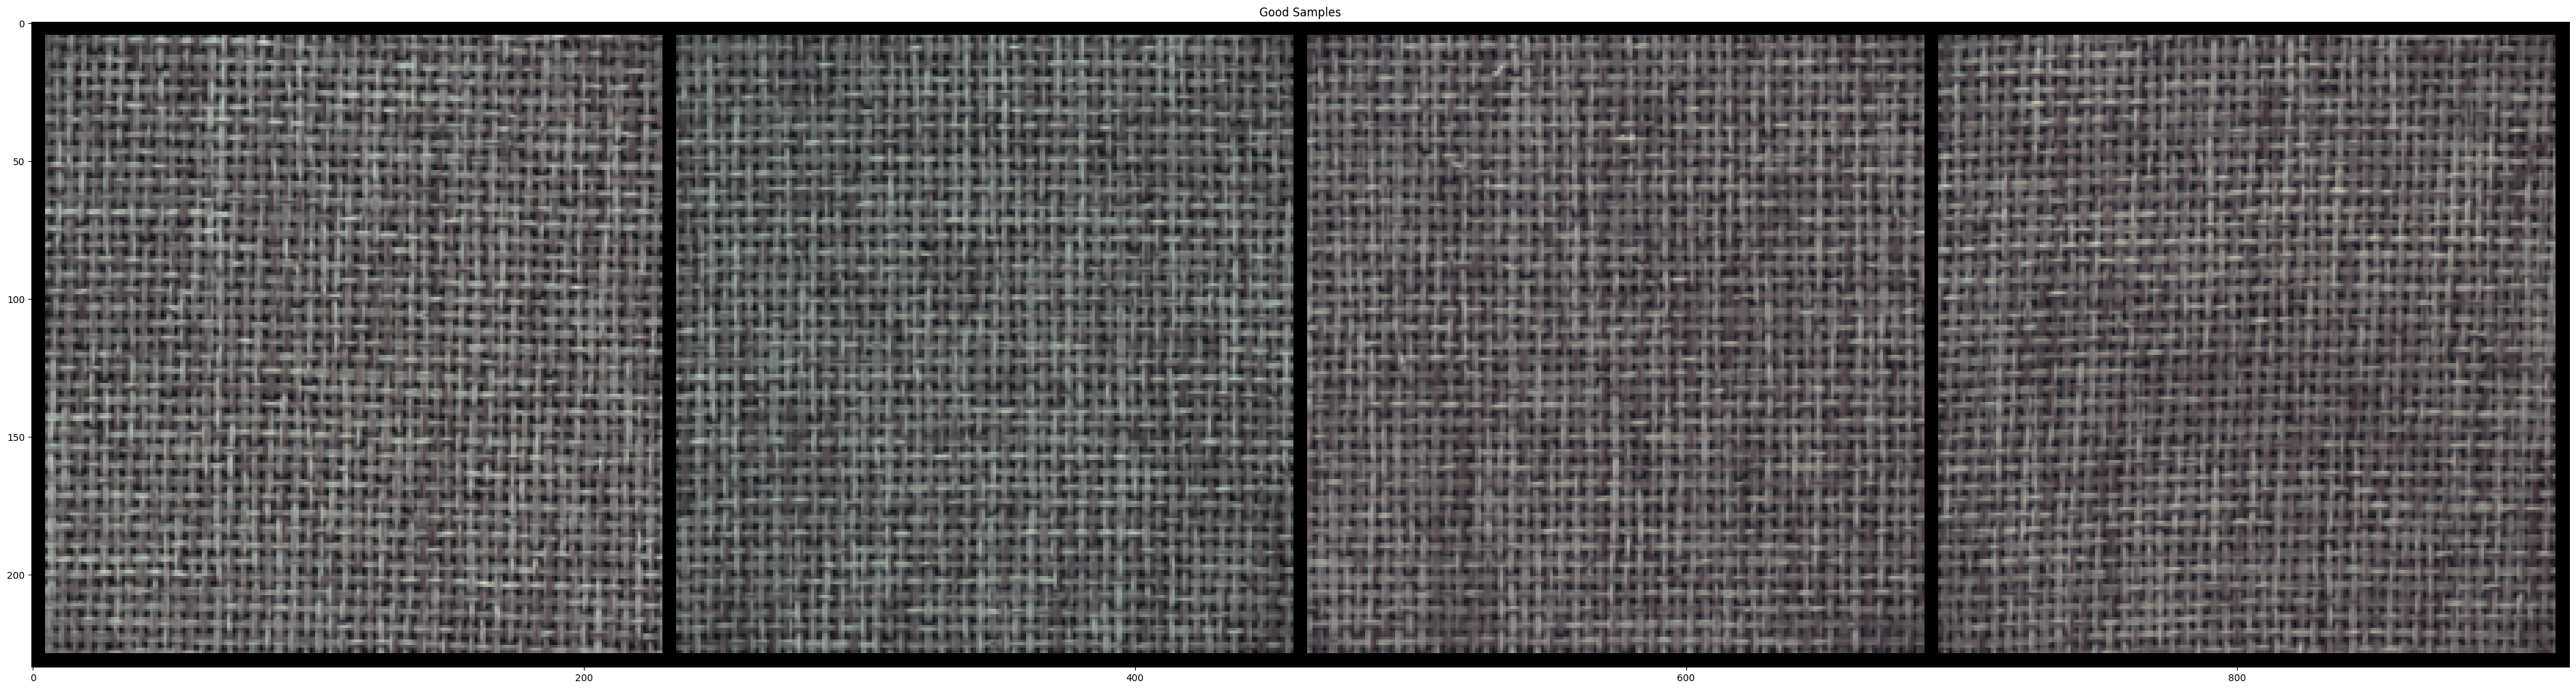

In [8]:
import torchvision

plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0)) # Permute dimensions (height, width, channels) for visualization
plt.title("Good Samples")
plt.show()

## Convolutional Autoencoder

### Train autoencoder model

In [9]:
import torch.nn.functional as F
from torch import nn

input_image = Image.open("carpet/train/good/000.png")
input_image = transform(input_image)
print(input_image.shape)

input_image = input_image.unsqueeze(0) # adds an extra dimension (representing batch size)
print(input_image.shape)

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
ap3 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap3(c3(x))
print(x.shape)

print("Final Latent Space")

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1)
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1)
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1)
x = c6(x)
print(x.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
Final Latent Space
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [10]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)
output_image = model(input_image)
print(output_image.shape)

torch.Size([1, 3, 224, 224])


In [11]:
# Define the loss function and optimizer

model.cuda() # Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Trainig Loop

In [12]:
from tqdm import tqdm

In [13]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train() # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() # Clears the gradients of all optimized tensors
        loss.backward() # Computes the gradients of the loss function with respect to the model parameters
        optimizer.step() # Updates the model parameters using the computed gradients
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval() # Set model to evaluation model
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label="Training Loss")
plt.plot(Validation_Loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# Save the model
# torch.save(model.state_dict(), "simple_autoencoder_l2_loss.pth")
# model.eval()

ckpoints = torch.load("simple_autoencoder_l2_loss.pth")
model.load_state_dict(ckpoints)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_32256\2307060762.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load("simple_autoencoder_l2_loss.pth")


<All keys matched successfully>

## Reconstruction of images

### Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

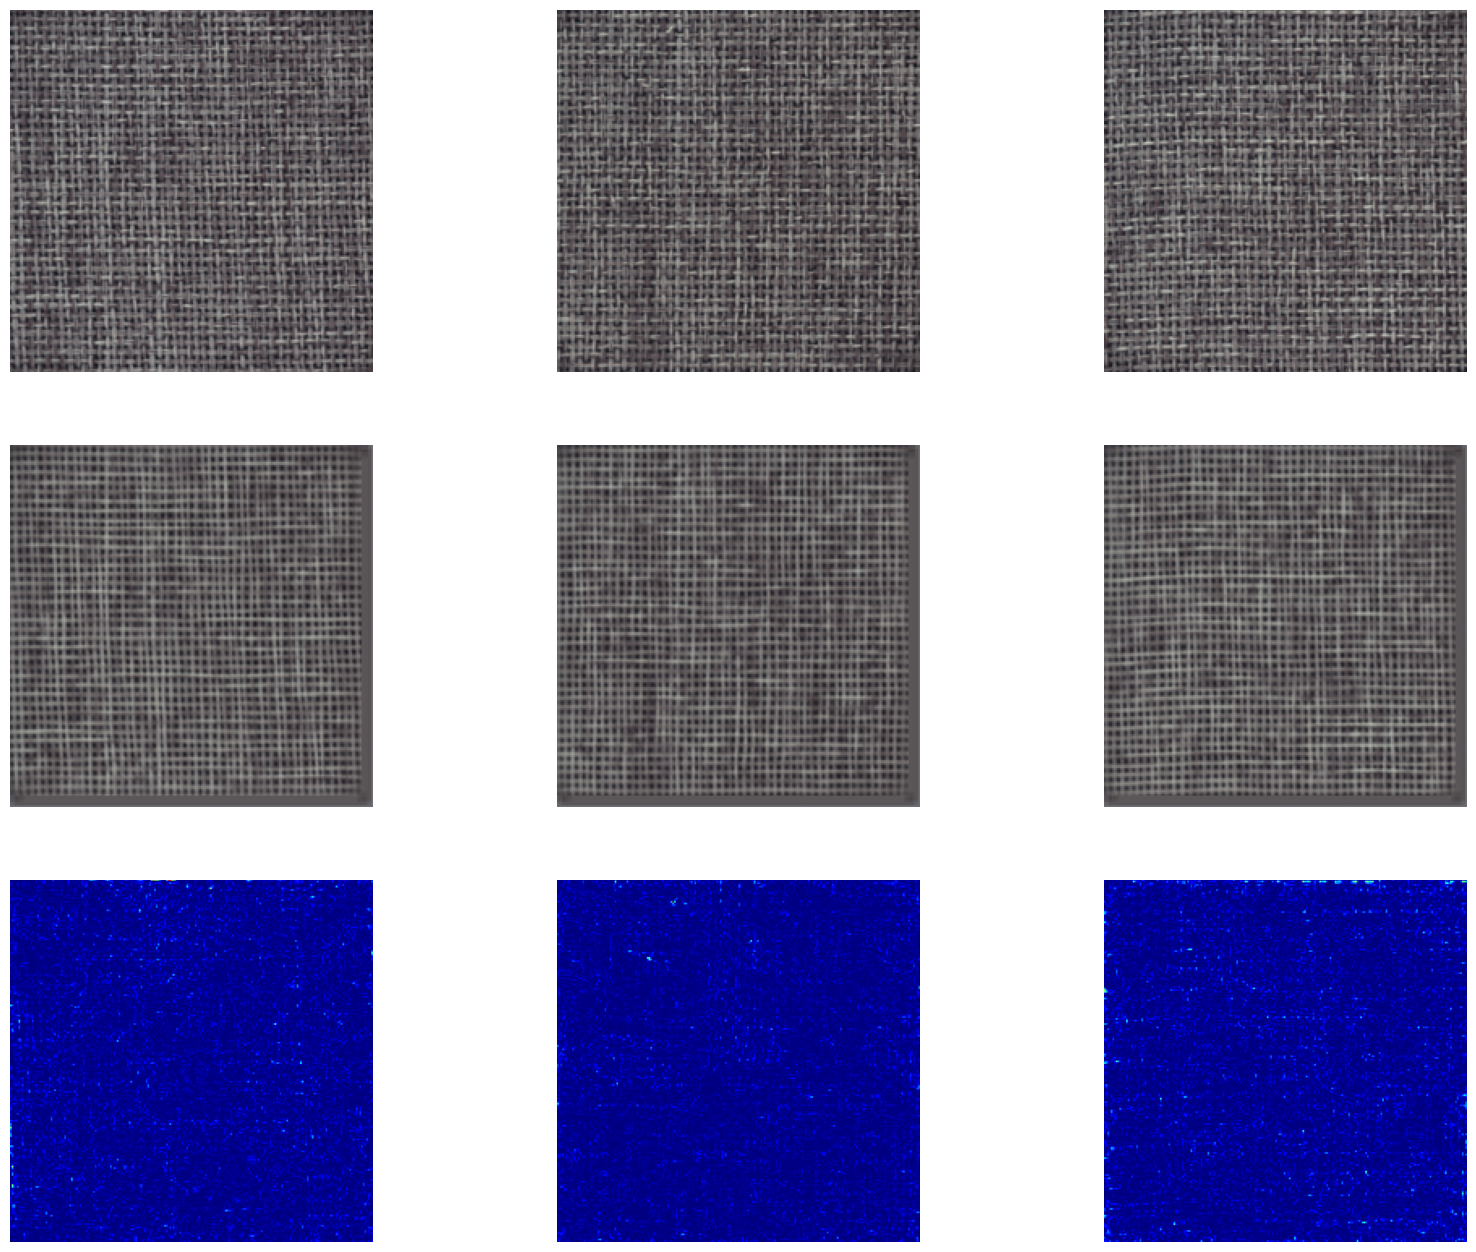

In [15]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error = ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap="jet", vmax=torch.max(recon_error[i]))
    ax[0, i].axis("OFF")
    ax[1, i].axis("OFF")
    ax[2, i].axis("OFF")
plt.show()

### Reconstruction of bad images

#### Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

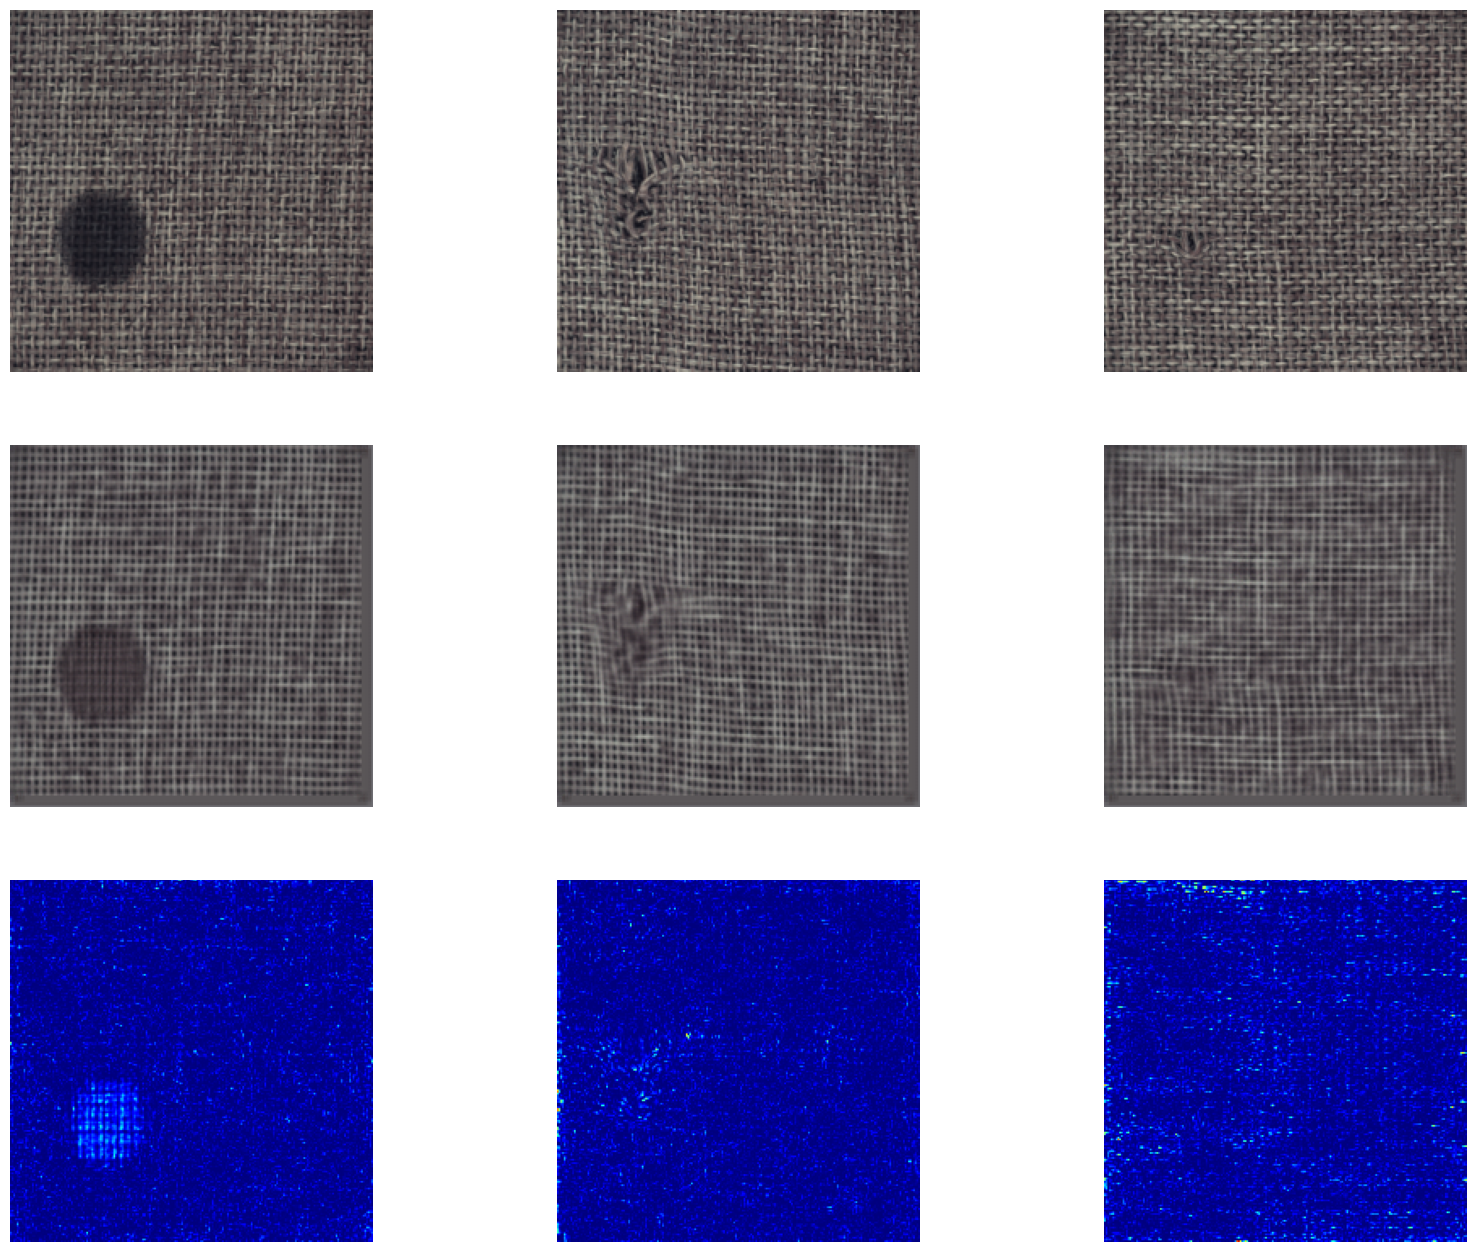

In [16]:
test_image_1 = transform(Image.open("carpet/test/color/000.png"))
test_image_2 = transform(Image.open("carpet/test/cut/000.png"))
test_image_3 = transform(Image.open("carpet/test/hole/000.png"))

data = torch.stack([test_image_1, test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)

recon_error = ((data-recon)**2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap="jet", vmax=torch.max(recon_error[i]))
    ax[0, i].axis("OFF")
    ax[1, i].axis("OFF")
    ax[2, i].axis("OFF")
plt.show()

### Obtain the fault detection accuracy

In [17]:
RECON_ERROR = []
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean = ((data-recon)**2).mean(axis=(1))[:, 0:-10, 0:-10].mean(axis=(1, 2))

        RECON_ERROR.append(data_recon_squared_mean)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

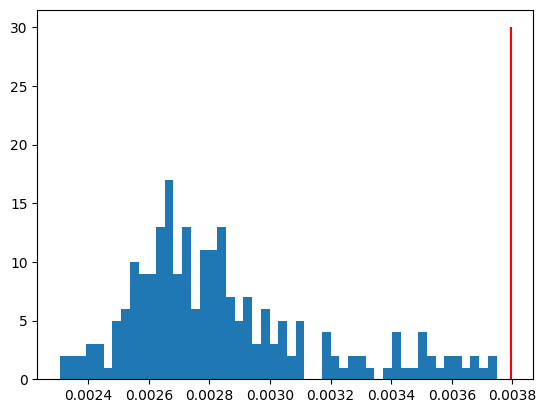

In [18]:
import numpy as np

best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, colors='r')
plt.show()

In [19]:
from pathlib import Path

In [20]:
y_true = []
y_pred = []
y_score = []

model.eval()

with torch.no_grad():

    test_path = Path("carpet/test")

    for path in test_path.glob("*/*.png"):
        fault_type = path.parts[-2]
        
        # if fault_type != "good":
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_images = model(test_image)

        y_score_image = ((test_image - recon_images)**2).mean(axis=(1))[:, 0:-10, 0:-10].mean()

        y_pred_image = 1 * (y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == "good" else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

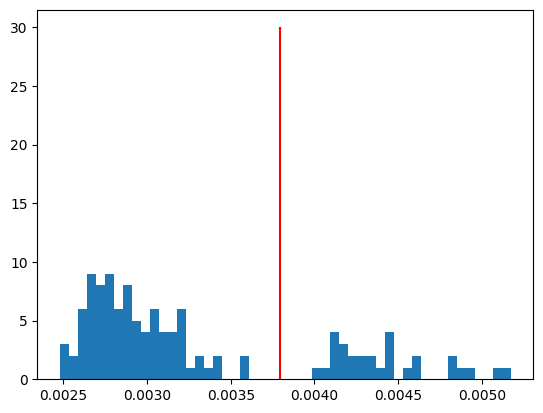

In [21]:
plt.hist(y_score, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, colors='r')
plt.show()

AUC-ROC Score: 0.4382022471910112


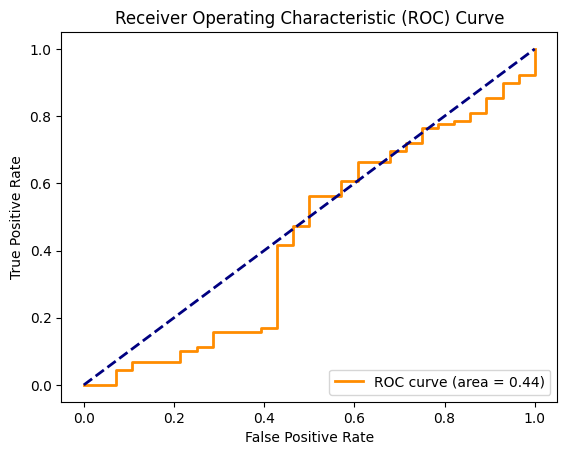

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

# Calculate AUC-ROC curve
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % auc_roc_score)
plt.plot([0, 1], [0, 1], color = "navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# CNN ResNet Segmentation Model

## Import Libraries

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Usuario\anaconda3\envs\AD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SetUp Data

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_image_path = Path("carpet/train")

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

## Load a pretrained ResNet Model

In [3]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook to extract feature maps
        def hook(module, input, output):
            """This hook saves the extracted feature map on self.featured"""
            self.features.append(output)
        
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)
        
        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2] # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1) # Merge the resized feature maps

        return patch

torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 1536, 28, 28])


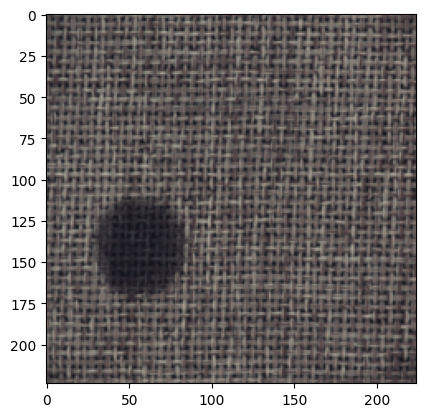

In [4]:
image = Image.open("carpet/test/color/000.png")
image = transform(image).unsqueeze(0)

backbone = resnet_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1, 2, 0))
plt.show()

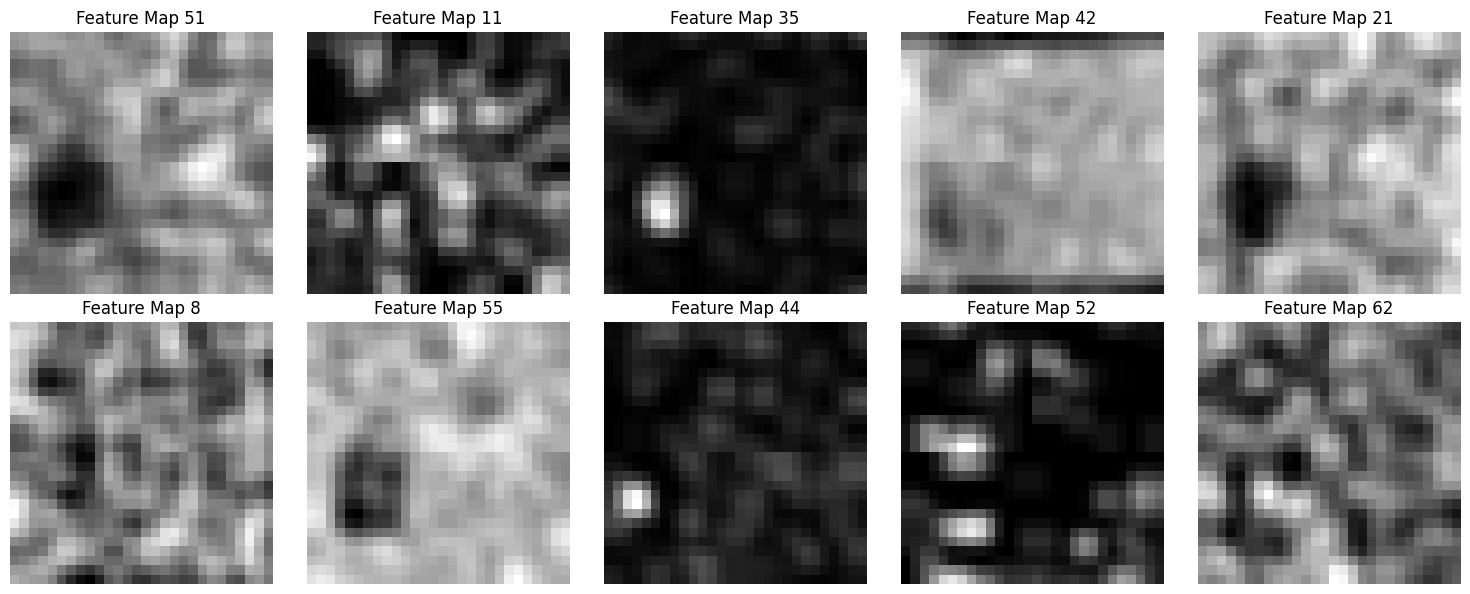

In [5]:
# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0, idx].detach().cpu(), cmap="grey")
    axes[row, col].set_title(f"Feature Map {idx}")
    axes[row, col].axis("off")
plt.tight_layout()
plt.show()

## The Autoencoder Model

In [6]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2*latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2*latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2*latent_dim) // 2, 2*latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2*latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2*latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2*latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2*latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2*latent_dim, (in_channels + 2*latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2*latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2*latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
backbone.cuda()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data, _ in train_loader:
        with torch.no_grad():
            features = backbone(data.cuda())
        # Forward pass
        output = model(features)
        # Compute the loss
        loss = criterion(output, features)
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            features = backbone(data.cuda())
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))
    
plt.plot(Loss, label="Training Loss")
plt.plot(Validation_Loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "autoencoder_with_resnet_deep_features.pth")

In [9]:
ckpoints = torch.load("autoencoder_with_resnet_deep_features.pth")
model.load_state_dict(ckpoints)

model.eval()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12000\892666522.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load("autoencoder_with_resnet_deep_feature

FeatCAE(
  (encoder): Sequential(
    (0): Conv2d(1536, 868, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(868, 200, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(200, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(100, 200, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(200, 868, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(868, 1536, kernel_size=(1, 1), stride=(1, 1))
  )
)

## Prediction of heatmap

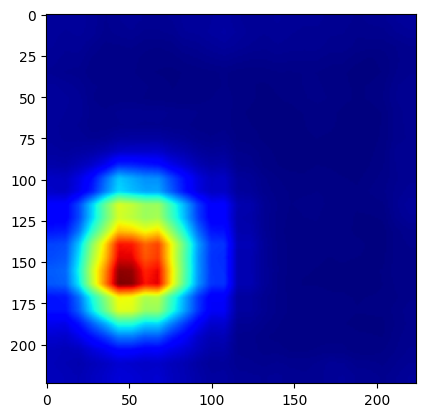

In [10]:
image = Image.open("carpet/test/color/000.png")
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image.cuda())
    recon = model(features)

recon_error = ((features-recon)**2).mean(axis=(1)).unsqueeze(0)

segm_map = torch.nn.functional.interpolate(
    recon_error,
    size=(224, 224),
    mode="bilinear"
)

plt.imshow(segm_map.squeeze().cpu().numpy(), cmap="jet")
plt.show()

### For OK Images

In [11]:
def decision_function(segm_map):

    mean_top10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor, descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top10_values.append(mean_top_10_value)
    
    return torch.stack(mean_top10_values)

In [12]:
model.eval()

RECON_ERROR = []
for data, _ in train_loader:

    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    
    # Compute the loss
    segm_map = ((features-recon)**2).mean(axis=(1))[:, 3:-3, 3:-3]
    anomaly_score = decision_function(segm_map)

    RECON_ERROR.append(anomaly_score)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

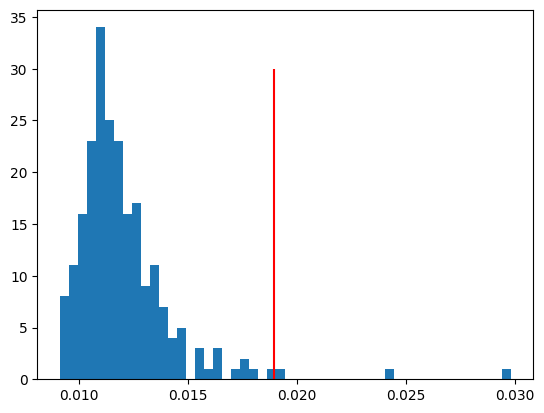

In [13]:
best_threshold = np.mean(RECON_ERROR) + 3*np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, color="r")
plt.show()

### For NOK Images

In [14]:
y_true = []
y_pred = []
y_score = []

model.eval()
backbone.eval()

test_path = Path("carpet/test")

for path in test_path.glob("*/*.png"):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features-recon)**2).mean(axis=(1))[:, 3:-3, 3:-3]
    y_score_image = decision_function(segm_map=segm_map)

    y_pred_image = 1*(y_score_image >= best_threshold)

    y_true_image = 0 if fault_type == "good" else 1

    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

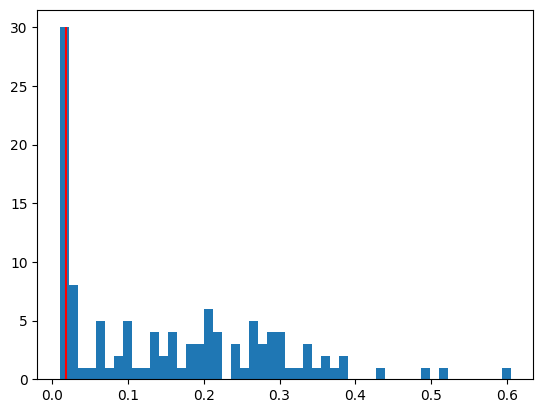

In [15]:
plt.hist(y_score, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, color="r")
plt.show()

## Evaluate metrics

AUC-ROC Score: 0.9867576243980738


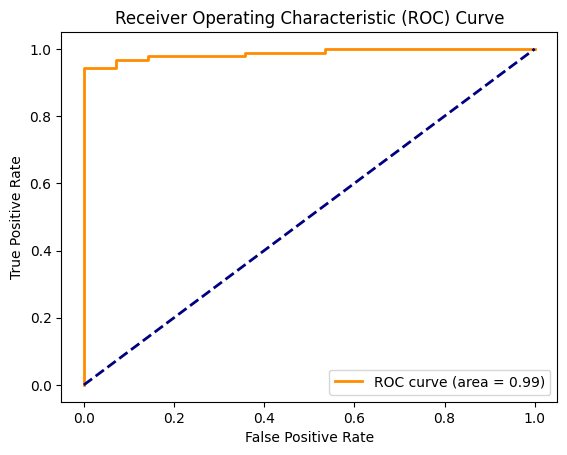

best_threshold = 0.022256096825003624


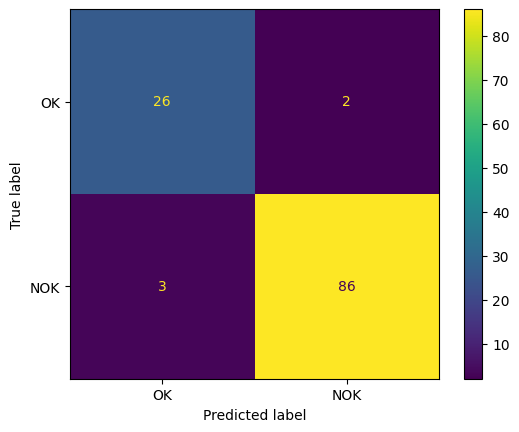

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

# ResNet KNN Model

## Import Libraries

In [2]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Usuario\anaconda3\envs\AD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Up

### Load a pretrained Resnet Model

In [3]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
model.eval()

for param in model.parameters():
    param.requires_grad = False

del resnet_model

### Prepare data transformations

In [4]:
transform = ResNet50_Weights.DEFAULT.transforms()

## Visualize Embeddings

In [5]:
folder_path = Path("carpet/test/color")

class_labels = []
y_true = []
resnet_features = []

for classes in ["color", "good", "cut", "hole", "metal_contamination", "thread"]:
    folder_path = Path("carpet/test/{}".format(classes))

    for pth in tqdm(folder_path.iterdir(), leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = model(test_image)
            resnet_features.append(features.squeeze().cpu().detach().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == "good" else 1)

resnet_features = np.array(resnet_features)

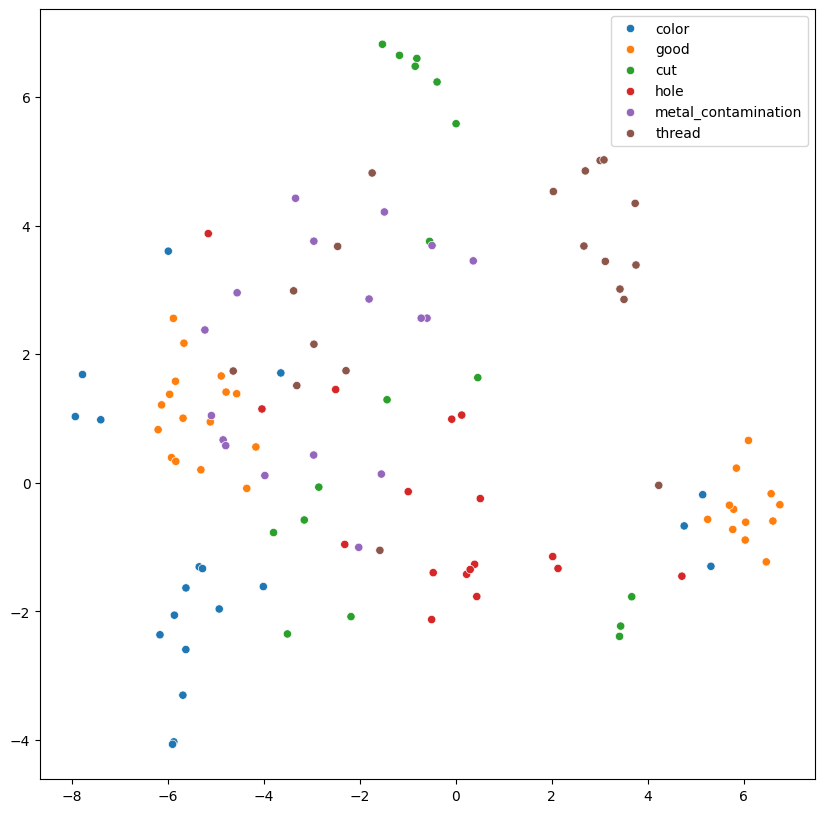

In [6]:
from sklearn.manifold import TSNE

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=41)
resnet_features_2d = tsne.fit_transform(resnet_features)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=resnet_features_2d[:, 0], y=resnet_features_2d[:, 1], hue=class_labels)
plt.show()

## Memory Bank

### Create a memory bank

In [7]:
memory_bank = []

folder_path = Path("carpet/train/good")

for pth in tqdm(folder_path.iterdir(), leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = model(data)
        memory_bank.append(features.squeeze().cpu().detach())
    
memory_bank = torch.stack(memory_bank).cuda()

### Plot the std of columns in the memory bank

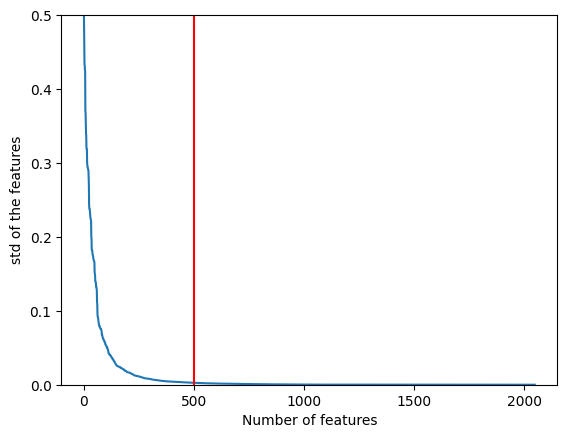

In [8]:
values, indices = torch.sort(memory_bank.std(dim=0))

plt.plot(values.cpu().numpy()[::-1])
plt.vlines(x=500, ymin=0, ymax=0.5, colors="red")
plt.ylim([0, 0.5])
plt.ylabel("std of the features")
plt.xlabel("Number of features")
plt.show()

In [9]:
values, indices = torch.sort(memory_bank.std(dim=0))
selected_indices = indices[-500:]
memory_bank = memory_bank[:, selected_indices]

In [10]:
memory_bank.shape

torch.Size([280, 500])

### For OK images

In [12]:
y_score = []

k=50

folder_path = Path("carpet/train/good")

for pth in tqdm(folder_path.iterdir(), leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = model(data).squeeze()
    # Calculate the pair-wise distance
    dist, _ = torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))
    dist = dist[:k].mean() # K nearest neighbours
    y_score.append(dist.cpu().numpy())

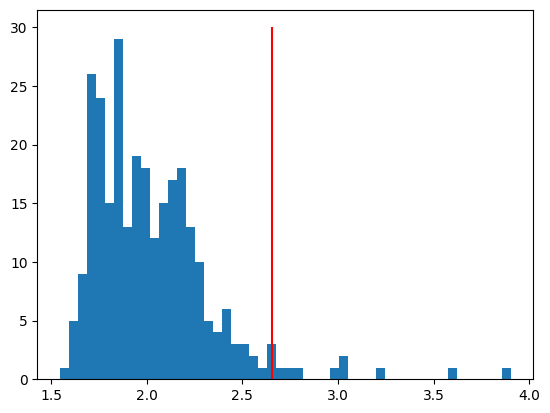

In [13]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, colors="r")
plt.show()

### For NOK images

In [14]:
folder_path = Path(r'carpet\test\color')

class_labels = []
y_true = []
resnet_features = []
y_score = []

for classes in ['color','good','cut','hole','metal_contamination','thread']:
    folder_path = Path(r'carpet\test\{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = model(test_image).squeeze()    
            dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))#[-10:].mean()
            dist = dist[:k].mean()
            y_score.append(dist.cpu().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

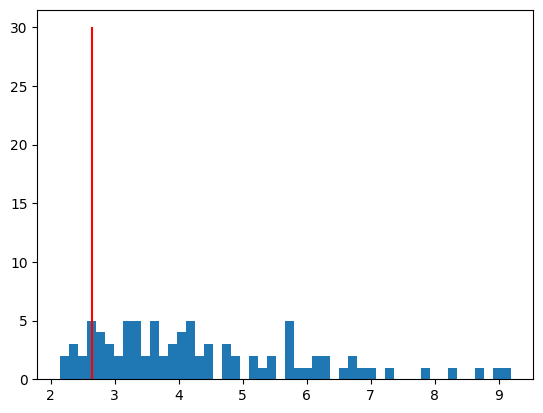

In [15]:
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

### Evaluation matrix

AUC-ROC Score: 0.7395666131621188


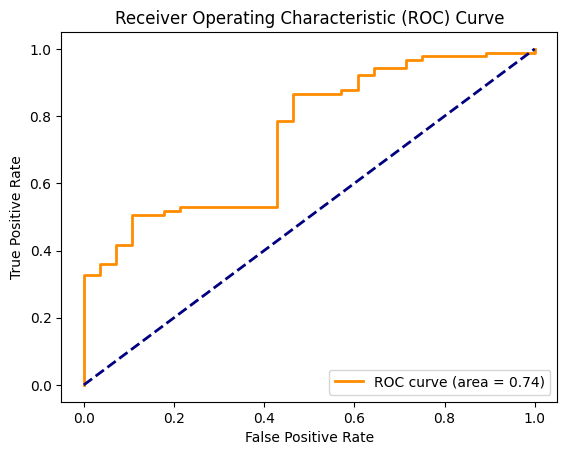

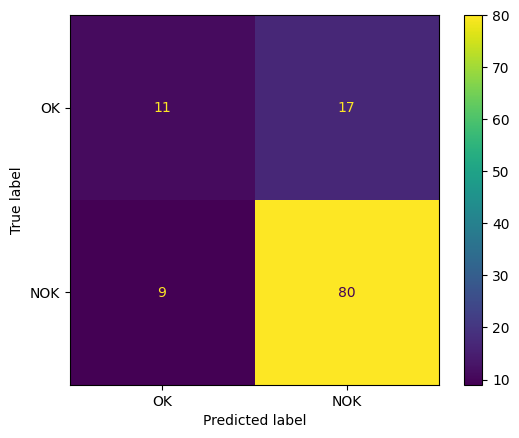

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

# PatchCore Model

## Import Libraries

In [17]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## Load a pretrained Resnet Model

In [ ]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)            
        self.model.layer3[-1].register_forward_hook(hook) 

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps
        patch = patch.reshape(patch.shape[1], -1).T   # Craete a column tensor

        return patch

In [22]:
image = Image.open("carpet/test/color/000.png")
image = transform(image).unsqueeze(0).cuda()

backbone = resnet_feature_extractor().cuda()
feature = backbone(image)

print(feature.shape)

torch.Size([784, 1536])


## Create memory bank from 'normal' data

In [23]:
memory_bank = []

folder_path = Path("carpet/train/good")

for pth in tqdm(folder_path.iterdir(), leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = backbone(data)
        memory_bank.append(features.cpu().detach())
    
memory_bank = torch.cat(memory_bank, dim=0).cuda()

## Only select 10% of total patches to avoid long inference time and computation

In [24]:
selected_indices = np.random.choice(len(memory_bank), size=len(memory_bank)//10, replace=False)
memory_bank = memory_bank[selected_indices]

## For OK images

In [25]:
y_score=[]
folder_path = Path('carpet/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = backbone(data)
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1) 
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28) 

    y_score.append(s_star.cpu().numpy())

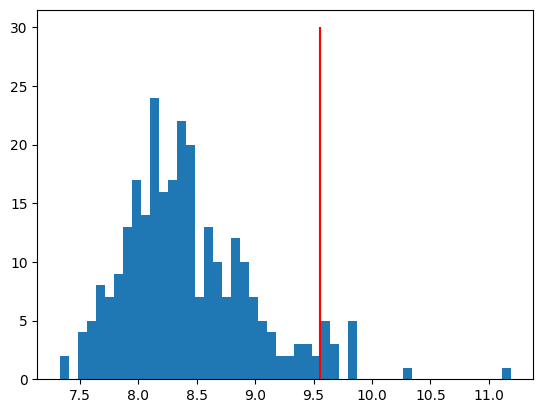

In [26]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

## For NOK images

In [27]:
y_score = []
y_true=[]

for classes in ['color','good','cut','hole','metal_contamination','thread']:
    folder_path = Path(r'carpet\test\{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)

        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1) 
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28) 

        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)

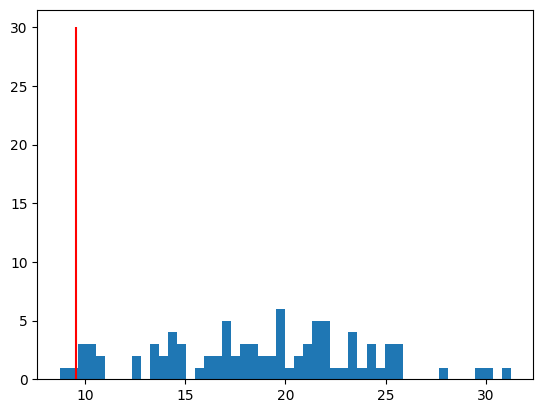

In [ ]:
# plotting the y_score values which do not belong to 'good' class

y_score_nok = [score for score, true in zip(y_score, y_true) if true==1]
plt.hist(y_score_nok, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, color='r')
plt.show()

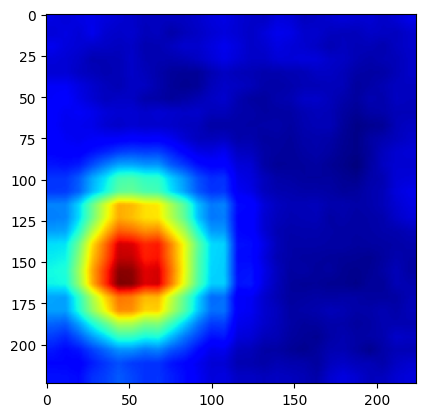

In [30]:
test_image = transform(Image.open('carpet/test/color/000.png')).cuda().unsqueeze(0)
features = backbone(test_image)

distances = torch.cdist(features, memory_bank, p=2.0)
dist_score, dist_score_idxs = torch.min(distances, dim=1) 
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.cpu().squeeze(), cmap='jet')
plt.show()

## Evaluation Metrics

AUC-ROC Score: 0.9739165329052969


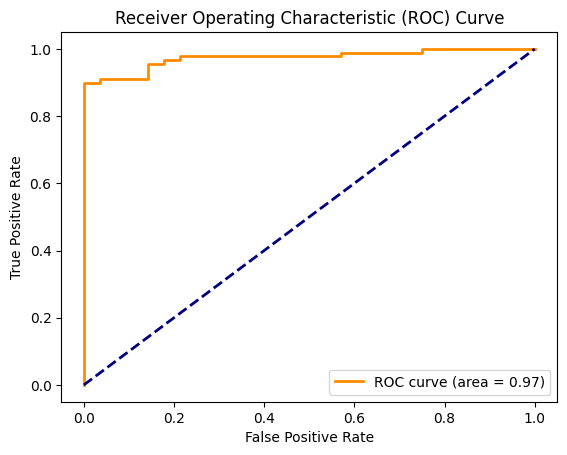

best_threshold = 9.911355972290039


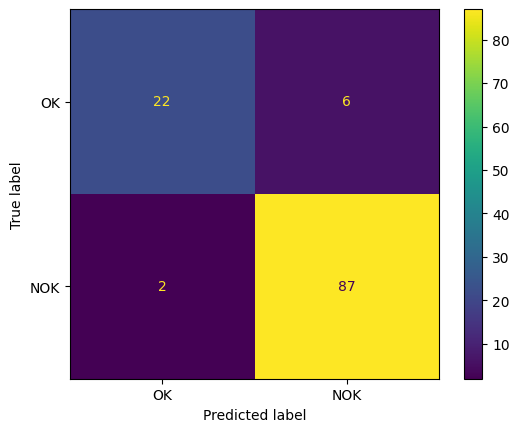

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

## Print out the prediction on the test set

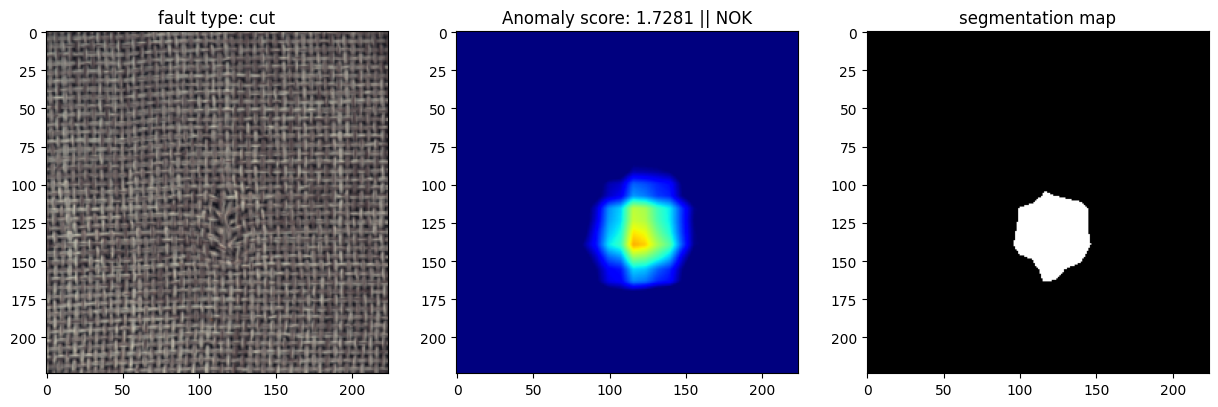

In [36]:
import time
from IPython.display import clear_output

backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'): 

    fault_type = path.parts[-2]

    if fault_type in ['cut']:
            
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        
        with torch.no_grad():
            features = backbone(test_image)
        # Forward pass
        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1) 
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28) 
        segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                    segm_map,
                    size=(224, 224),
                    mode='bilinear'
                ).cpu().squeeze().numpy()
        
        y_score_image = s_star.cpu().numpy()
        
        y_pred_image = 1*(y_score_image >= best_threshold)
        class_label = ['OK','NOK']

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map
        plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2) 
        plt.title(f'Anomaly score: {y_score_image / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold*1.25), cmap='gray')
        plt.title(f'segmentation map')
        
        plt.show()

        time.sleep(0.05)
        clear_output(wait=True)